In [1]:
%load_ext rpy2.ipython

In [2]:
%R require(ggplot2)

/opt/intel/intelpython35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Carregando pacotes exigidos: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
from daal.data_management import AOSNumericTable
from daal.data_management import SOANumericTable
from daal.data_management import BlockDescriptor_Intc
from daal.data_management import BlockDescriptor
from daal.data_management import BlockDescriptor_Float64
from daal.data_management import readOnly
from daal.data_management import readWrite
from daal.data_management import data_feature_utils
from daal.data_management import HomogenNumericTable
from daal.data_management import NumericTableIface
from daal.data_management import MergedNumericTable
from daal.data_management import FileDataSource
from daal.data_management import StringDataSource
from daal.data_management import DataSourceIface
from daal.data_management import packed_mask

from daal.algorithms.linear_regression import training
from daal.algorithms.linear_regression import prediction

import daal.algorithms.normalization.zscore as zscore

from daal import step1Local
from daal import step2Master


import numpy as np

import math

In [4]:
def printNumericTable(data_table, message='', num_printed_rows=0, num_printed_cols=0,
                      interval=10):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()

    if num_printed_rows != 0:
        num_printed_rows = min(num_rows, num_printed_rows)
    else:
        num_printed_rows = num_rows

    if num_printed_cols != 0:
        num_printed_cols = min(num_cols, num_printed_cols)
    else:
        num_printed_cols = num_cols

    block = BlockDescriptor()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        data_table.getBlockOfRows(0, num_rows, readOnly, block)
        printArray(block.getArray(), num_printed_cols, num_printed_rows,
                   num_cols, message, interval)
        data_table.releaseBlockOfRows(block)
    else:
        packed_table = data_table.getBlockOfRowsAsDouble(0, num_rows)
        if isLower(layout):
            printLowerArray(packed_table, num_printed_rows, message, interval)
        elif isUpper(layout):
            printUpperArray(packed_table, num_printed_cols, num_printed_rows,
                            num_cols, message, interval)
        
def isFull(layout):
    layout_int = int(layout)
    if packed_mask & layout_int:
        return False
    return True


def printArray(array, num_printed_cols, num_printed_rows, num_cols, message,
               interval=10, flt64=True):
    print(message)
    flat_array = array.flatten()
    decimals = '3' if flt64 else '0'
    for i in range(num_printed_rows):
        for j in range(num_printed_cols):
            print("{:<{width}.{dec}f}".format(
                flat_array[i * num_cols + j], width=interval, dec=decimals), end=''
            )
        print()
    print()

    
def getNPArray(data_table):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()
    np_array = np.ones((num_rows, num_cols), dtype=np.int)
    block = BlockDescriptor()
    data_table.getBlockOfRows(0, num_rows, readOnly, block)
    np_array = block.getArray()
    data_table.releaseBlockOfRows(block)
    return np_array

</div>
    <h1>Leveraging Data Analytics with Intel DAAL</h1>
    <h3>Raphael Mendes de Oliveira Cóbe</h3>
    <p>rmcobe@ncc.unesp.br</p>
    <p>Source available on <a href="https://github.com/raphaelmcobe/intel-datascience-workshop">Github</a>

</div>
<div style="width:80%; margin-left:auto; margin-right:auto;">
    <img src=intel_logo.png style="height:170px; float:left;"/>
    <img src=ncc_logo.png style="height:170px; float:right;"/></div>
<div>

# NCC/Unesp

* GridUnesp
    * 256 WorkerNodes
    
* Sprace
    * Tier-2 Cern
    * 1PB Raw Data

# Data Science

* Recently open field that put together lots of concepts of other fields, such as:
  * Getting Data (**Open Data!**);
  * Data Analysis;
  * Data Visualization;
  * Data Modelling;
  * **Prediction**;
  * Big Data

# Intel Data Analytics Acceleration Library
* Delivers high application performance across spectrum of Intel®-architecture devices
* Speeds time-to-value through data source and environment integration 
* Reduces application development time via wide selection of pre-optimized advanced analytics algorithms

# Data Management

* Data Table
<center><img src="datatable.png" width=400 style="transform:rotate(90deg);"/></center>

# Data Management and Data Structures

* **Heterogeneous Tables** are used when there are multiple data types in a data set (e.g.double, string, etc.) 
    * Structures supported: **Structures of Arrays (SoA)** and **Arrays of Structures (AoS)**. 
* **Homogeneous Tables** are used when the data set has only one type of data. 
    * Two types of homogeneous tables: **dense** and **sparse**. 

# Data Management and Data Structures

* **Matrices** are used when the application requires matrix algebra type workloads
    * Three kinds of matrices supported: **dense matrix**, **packed symmetric matrix**, and **packed triangular matri-ces**. 




# AOS vs SOA

<center><img src="aos.png" style="height:220px;"/></center>
<center><img src="soa.png" style="height:320px;"/></center>

# Loading Data from a NumPy Array (AOS)

* Loading from a NumPy Array:

In [5]:
points = np.array([(0.5, -1.3, 1, 100.1),
                   (2.5, -3.3, 2, 200.2),
                   (4.5, -5.3, 2, 350.3),
                   (6.5, -7.3, 0, 470.4),
                   (8.5, -9.3, 1, 270.5)],
                  dtype=[('x','f4'), ('y','f4'), 
                         ('categ','i4'), ('value','f8')])  


dataTable = AOSNumericTable(points)    

# Retrieving values of a Feature
* By Column

In [6]:
nObservations = len(points)
firstReadRow = 2
readFeatureIdx = 0

floatBlock = BlockDescriptor_Float64()
dataTable.getBlockOfColumnValues(readFeatureIdx, firstReadRow,
                                 nObservations, readOnly, floatBlock)
dataTable.releaseBlockOfColumnValues(floatBlock)
print(floatBlock.getArray())

[[ 4.5]
 [ 6.5]
 [ 8.5]]


# Retrieving values of a Feature
* By Rows

In [7]:
firstReadRow = 2
nRead = 3
doubleBlock = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readOnly, doubleBlock)

print("Block of Rows:")
print(doubleBlock.getArray())


Block of Rows:
[[   4.5          -5.30000019    2.          350.3       ]
 [   6.5          -7.30000019    0.          470.4       ]
 [   8.5          -9.30000019    1.          270.5       ]]


# Loading Data from a NumPy Array (SOA)

In [8]:
def toString(v):
    if v == data_feature_utils.DAAL_CATEGORICAL:
        return "DAAL_CATEGORICAL"
    elif v == data_feature_utils.DAAL_ORDINAL:
        return "DAAL_ORDINAL"
    elif v == data_feature_utils.DAAL_CONTINUOUS:
        return "DAAL_CONTINUOUS"
    else:
        return "[Unknown FeatureType]"


In [9]:
nObservations = 10
nFeatures = 4

dDataSOA = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8], dtype=np.float64)
fDataSOA = np.array([3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0], dtype=np.float32)
iDataSOA = np.array([-10, -20, -30, -40, -50, -60, -70, -80, -90, -100], dtype=np.int32)
cDataSOA = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], dtype=np.uint8)

dataTable = SOANumericTable(nFeatures, nObservations)
dataTable.setArray(cDataSOA, 0)
dataTable.setArray(fDataSOA, 1)
dataTable.setArray(dDataSOA, 2)
dataTable.setArray(iDataSOA, 3)

# Setting and Retrieving data Types

* Setting datatypes:

In [10]:
dict = dataTable.getDictionary()
dict[0].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[1].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[2].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[3].featureType = data_feature_utils.DAAL_CATEGORICAL

* Retrieving datatypes:

In [11]:
pDictionary = dataTable.getDictionary()
print("\nDataTypes:")
for i in range(0, nFeatures):
    featureType = pDictionary[i].featureType
    print("{}: {}".format(i, toString(featureType)), end=', ')



DataTypes:
0: DAAL_CONTINUOUS, 1: DAAL_CONTINUOUS, 2: DAAL_CONTINUOUS, 3: DAAL_CATEGORICAL, 

# Merging data

* `MergedNumericTable`




In [12]:
data1 = np.array([(0.0, 0.1, 0.2, 0.3, 0.4),
                  (1.0, 1.1, 1.2, 1.3, 1.4),
                  (2.0, 2.1, 2.2, 2.3, 2.4),
                  (3.0, 3.1, 3.2, 3.3, 3.4),
                  (4.0, 4.1, 4.2, 4.3, 4.4),])

data2 = np.array([(0.5, 0.6, 0.7, 0.8, 0.9, 1),
                  (1.5, 1.6, 1.7, 1.8, 1.9, 2),
                  (2.5, 2.6, 2.7, 2.8, 2.9, 3),
                  (3.5, 3.6, 3.7, 3.8, 3.9, 4),
                  (4.5, 4.6, 4.7, 4.8, 4.9, 5),])


dataTable1 = HomogenNumericTable(data1)
dataTable2 = HomogenNumericTable(data2)

dataTable = MergedNumericTable()
dataTable.addNumericTable(dataTable1)
dataTable.addNumericTable(dataTable2)

# Merging data

* Modifying data

In [13]:
nFeatures1 = 5
nFeatures2 = 6
firstReadRow = 3
nRead = 1


block = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readWrite, block)
print(block.getArray().flatten())

selected_row = block.getArray()
for i in range(0,len(selected_row[0])):
    selected_row[0][i] = 10
    
print(block.getArray())
dataTable.releaseBlockOfRows(block)



[ 3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4. ]
[[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


# Merging data

* Modifying data (2)

In [14]:
dataTable1.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable1.releaseBlockOfRows(block)

dataTable2.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable2.releaseBlockOfRows(block)

[[ 10.  10.  10.  10.  10.]]
[[ 10.  10.  10.  10.  10.  10.]]


# Reading from CSV files

In [15]:
nFeatures = 4
nOutcomes = 1

trainDatasetFileName = './housing-train.csv'

trainDataSource = FileDataSource(trainDatasetFileName, 
                            DataSourceIface.notAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)

trainData = HomogenNumericTable(nFeatures, 0, 
                                NumericTableIface.notAllocate)
trainOutcome = HomogenNumericTable(nOutcomes, 0, 
                                   NumericTableIface.notAllocate)
mergedData = MergedNumericTable(trainOutcome, trainData)
nObservations = trainDataSource.loadDataBlock(mergedData)
print("Observations read: {}".format(nObservations))


Observations read: 435


# Data Sampling

* With or without Replacement.

In [16]:
from numpy import genfromtxt
data = np.genfromtxt('housing-full.csv', delimiter=',')
sample = np.random.choice(len(data),size=math.floor(.8*len(data)),
                          replace=False)

select = np.in1d(range(data.shape[0]), sample)

print(len(data[select,:]))
print(len(data[~select,:]))

train_data = HomogenNumericTable(data[select,:])
test_data = HomogenNumericTable(data[~select,:])

print(train_data.getNumberOfRows())
print(test_data.getNumberOfRows())

436
110
436
110


# Data Normalization

In [17]:
dataSource2 = FileDataSource('housing-full.csv',
                            DataSourceIface.doAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)
dataSource2.loadDataBlock()

data2 = dataSource2.getNumericTable()


# Create an algorithm
algorithm = zscore.Batch(method=zscore.sumDense)

# Set an input object for the algorithm
algorithm.input.set(zscore.data, data2)

# Compute Z-score normalization function
res = algorithm.compute()



# Data Normalization

In [18]:
printNumericTable(data2, "First 10 rows of the input data:", 10)

printNumericTable(res.get(zscore.normalizedData), 
                  "First 10 rows of the z-score normalization result:", 10)


First 10 rows of the input data:
42000.000 5850.000  3.000     1.000     2.000     
38500.000 4000.000  2.000     1.000     1.000     
49500.000 3060.000  3.000     1.000     1.000     
60500.000 6650.000  3.000     1.000     2.000     
61000.000 6360.000  2.000     1.000     1.000     
66000.000 4160.000  3.000     1.000     1.000     
66000.000 3880.000  3.000     2.000     2.000     
69000.000 4160.000  3.000     1.000     3.000     
83800.000 4800.000  3.000     1.000     1.000     
88500.000 5500.000  3.000     2.000     4.000     

First 10 rows of the z-score normalization result:
-0.428    0.028     0.000     -0.000    0.000     
-0.485    -0.045    -0.000    -0.000    -0.000    
-0.305    -0.083    0.000     -0.000    -0.000    
-0.125    0.059     0.000     -0.000    0.000     
-0.117    0.048     -0.000    -0.000    -0.000    
-0.035    -0.039    0.000     -0.000    -0.000    
-0.035    -0.050    0.000     0.000     0.000     
0.014     -0.039    0.000     -0.000    0.000   

# Prediction

# Linear Regression

* Tries to fit a linear function to the data;
* Helps visualizing some data behaviours;

<!--<center><img src="lm.png" style="padding-top:30px;"/></center>-->

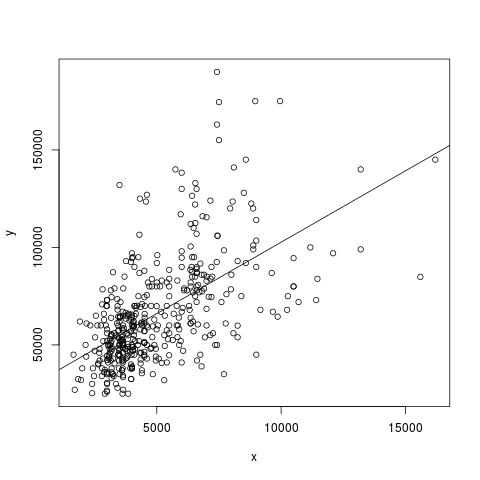

In [19]:
%%R 
dataset <- read.csv('housing-train.csv')
y <- dataset[,1]
x <- dataset[,2]
plot(x,y)
abline(lm(y~x))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the house size?

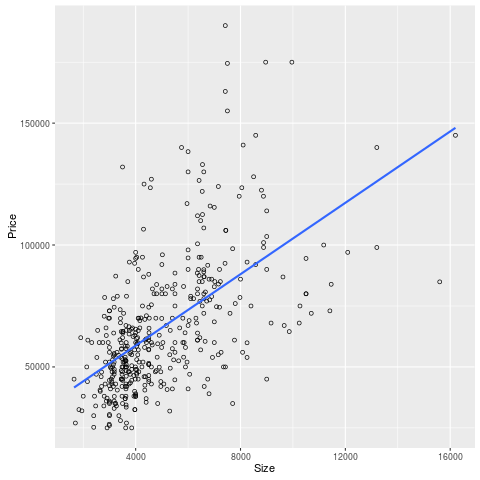

In [20]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,2], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Size")+ylab("Price"))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the number of bedrooms?

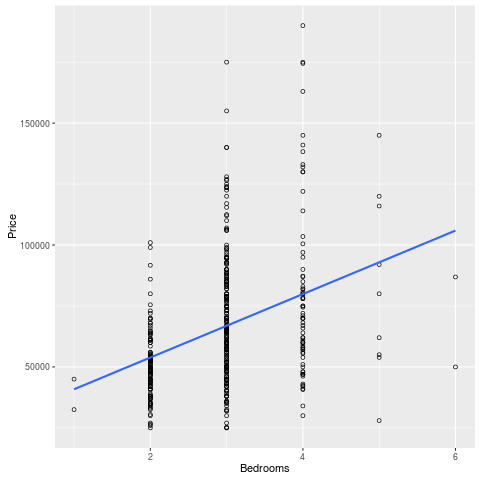

In [21]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,3], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Bedrooms")+ylab("Price"))

# Regression Problems

* Data set where a **right answer** is given as input to the problem
    * **We know actual prices for houses**
    * Learn what makes the price a certain value from the training data;
    * More right answers based on new training data where we don't know the price already.
* We also call this a regression problem
    * Predict continuous valued output (price)
    * No real discrete delineation 

# The math behind it

* Assume that there is a dependency between variables;
    * More specifically, $y$ depends *linearly* on $x_1, x_2, x_3, ..., x_n$
    * In most real world data, <font color='red'>regression is never Linear</font>;
<!--<center><img src="lm2.png" style="padding-top:30px;"/></center> -->


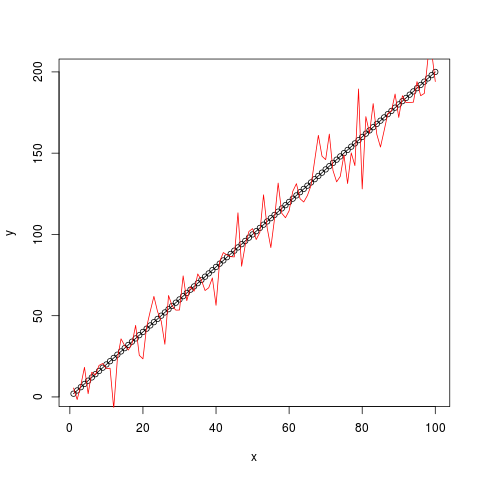

In [22]:
%%R
x <- 1:100
y <- x*2
plot(x,y)
lines(y)
z = y+(rnorm(length(y))*10)
lines(z, col="red")

# The math behind it

* Given samples $(x_i,y_i)$ where $1 \leq i \leq n$
    * Predict $y_{i+1}$ given the new information $x_{i+1}$
* We assume that the dependent variable can be modeled with: $y = \theta_0 + \theta_1x +\epsilon$ where
    * $\theta_0$ is the **intercept**
    * $\theta_1$ is the **slope**
    * $\epsilon$ is the **error**
* Given some estimates $\theta_0$ and $\theta_1$ for the model coeficients, we predict the outcome value $\hat{y}$  using: $\hat{y} = \theta_0+\theta_1x$
* The *ith* residual: $\epsilon_i = y_i - \hat{y}_i$
* A hypothesis takes in some variable;
* Uses parameters determined by a learning system
* Outputs a prediction based on that input

# The math behind it

* If $\theta_1 \geq 0$ then we get a positive slope;
* If $\theta_0 = 1.5$ and $\theta_1 = 0$ then we get straight line parallel with axis X along 1.5;
* The **squared error** is thus: $E=\sum_{i=1}^{m}(y_i - \hat{y}_i)^2$
* We face a **Minimization Problem**

# The math behind it - Normal Equation

* Derivate to get minimum, i.e., $\frac{d}{d\theta_1} = 0$ then solve for $\theta_1$
* Mean Squared Error: $E=\sum_{i=1}^{m}(y_i - \theta_1x_i)^2$
    * Simplify $\theta_0 = 0$<br />
    <center>
$\frac{d}{d\theta_1} = 0$ <br /><br />
</center>
<center>
$-2\sum_{i=1}^{m}x_i(y_i - \theta_1x_i) = 0$<br /><br />
</center>
<center>
$\sum_{i=1}^{m}x_iy_i = \theta_1\sum_{i=1}^{m}x_i^2$<br /><br />
</center>
<center>
$\theta_1 = \frac{\sum_{i=1}^{m}x_iy_i}{\sum_{i=1}^{m}x_i^2}$
</center>

# The math behind it

## Multiple Linear Regression

* We assume that the future data can be modeled with the following: $\hat{y} = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 $ 
* Let's consider now that the $\theta_0, \theta_1, \theta_2, ... \theta_n$ is a vector
* Also, the values of our features $x_1, x_2, x_3, ..., x_n$ are a vector and let's assume that $x_0=1$

$$
\theta=
\begin{bmatrix}
\theta_0\\
\theta_1\\
\theta_2\\
...\\
\theta_n\\
\end{bmatrix}
,\ X=
\begin{bmatrix}
x_0\\
x_1\\
x_2\\
...\\
x_n\\
\end{bmatrix}
$$

# The math behind it

## Multiple Linear Regression (2)

* Thus, in order to estimate $\hat{y}$ in terms of $\theta_0, \theta_1, \theta_2, ..., \theta_n$ and $x_0, x_1, x_2, ..., x_n$ we get:<br /><br />
$$
\hat{y} = \theta_0x_0 + \theta_1x_1+\theta_2x_2+\theta_3x_3+ ...+ \theta_nx_n
$$<br />
then, using a vector product notation we get:<br /><br />
$$
\theta^TX
$$

# The math behind it

## Multiple Linear Regression (3)

* Our **error E** now is a function of the $\theta_0, \theta_1, ... \theta_n$ variables: <br /><br />
$$E(\theta_0,\theta_1,...\theta_n) = \sum_{i=1}^{m} (y_i - \theta_0x_0 + \theta_1x_1+...+ \theta_nx_n)^2$$
<br /><br />
* In order to use the Normal Equation to solve for each $\theta_i$ we have to take the partial derivatives $\frac{\partial}{\partial \theta_i}$

# Error estimation

## Root Mean Square Error
* Differences between values predicted and the values observed;
* Same unit as the observation;<br /><br />
$$\sqrt{\frac{\sum_{i=1}^{m}(\hat{y}_i - y_i)}{m}}$$

# Error estimation

## $R^2$
* Amount of variance explained by the model
* Unitless;<br /><br />
$$SS_{res} = \sum_{i=1}^{m}(\hat{y}_i - y_i)$$<br/><br />
$$SS_{tot} = \sum_{i=1}^{m}(y_i - \bar{y})$$<br/><br />

# Error estimation

## $R^2$
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

# Training the Model

In [23]:
algorithm = training.Batch_Float64NormEqDense()
                                                                                                   
algorithm.input.set(training.data, trainData)
algorithm.input.set(training.dependentVariables, trainOutcome)
                                     
trainingResult = algorithm.compute()
printNumericTable(trainingResult.get(training.model).getBeta(), 
                  "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



In [24]:
%%R
dataset = read.csv("./housing-train.csv")
colnames(dataset) = c("price", "lotsize", "bedrooms", "bathrms", "stories")

dataset.test = read.csv("./housing-test.csv")

colnames(dataset.test) = c("price", "lotsize", "bedrooms", "bathrms", "stories")

model = lm(price ~ ., data=dataset)

print(summary(model)$r.squared)

result = predict(model, dataset.test[,2:5])

price.mean = mean(dataset$price)

ssreg = sum((result-price.mean)^2)

sstot = sum((dataset.test$price-price.mean)^2)

r.squared = cor(dataset.test$price, result)^2

print(r.squared)

print(ssreg/sstot)


SS.test.total      <- sum((dataset.test$price - mean(dataset$price))^2)
SS.test.residual   <- sum((dataset.test$price - result)^2)


test.rsq <- 1 - SS.test.residual/SS.test.total  
print(test.rsq)


sqrt(sum((result - dataset.test$price)^2 , na.rm = TRUE ) / nrow(dataset.test) )



[1] 0.5348178
[1] 0.4893394
[1] 0.8130583
[1] 0.5418781
[1] 16561.69


# The quality of the Model

In [25]:
algorithm = prediction.Batch()
algorithm.input.setTable(prediction.data, trainData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(trainOutcome)

real_values_mean = np.sum(real_values)/len(real_values)
ssreg = np.sum((prediction_result-real_values_mean)**2)
sstot = np.sum((real_values - real_values_mean)**2)
r_squared = ssreg / sstot

print(r_squared)

0.533399894442


# Testing your model

In [26]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(testDatasetFileName, 
                            DataSourceIface.notAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)

testData = HomogenNumericTable(nFeatures, 0, 
                               NumericTableIface.notAllocate)

testGroundTruth = HomogenNumericTable(nOutcomes, 0, 
                                      NumericTableIface.notAllocate)

mergedData = MergedNumericTable(testGroundTruth,testData)

nObservations = testDataSource.loadDataBlock(mergedData)

print("Testing points read: {}".format(nObservations))

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

Testing points read: 111


# Testing your Model

In [27]:
printNumericTable(predictionResult.get(prediction.prediction), 
          "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 



# Testing your Model

## Error Measures:

### $R^2$


In [28]:
prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(testGroundTruth)

training_data_outcome = getNPArray(trainOutcome)

values_mean = np.sum(training_data_outcome)/len(training_data_outcome)

ssres = np.sum((real_values - prediction_result)**2)
sstot = np.sum((real_values - values_mean)**2)

r_squared = 1 - ssres / sstot

print("{0:.2f}".format(r_squared))

0.54


# Testing your Model

## Error Measures:

### $RMSE$


In [29]:
prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(testGroundTruth)

rmse = math.sqrt(
    np.sum((prediction_result-real_values)**2)/len(real_values))

print("{0:.2f}".format(rmse))

16480.70


# Why Use it?

* Modes: 
    * **Batch**: the only compute method of a particular algorithm class is used; 
    * **Online**: this computation mode assumes that the data arrives in blocks;
        * `compute()` method each time new input becomes available.
        * When the last block of data arrives, call the `finalizeCompute()` method to produce final results;

# Why Use it?
* Modes:
    * **Distributed**: data sets distributed across several devices;
        * Assumes that the data set is split in *nblocks* blocks across computation nodes.
        * define the computation step for an algorithm; 

# Why Use it? Distributed!

* Provide the `computeStep` value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)
* Provide the computeStep value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)

# Distributed processing

<center><img src="distributed.png" style="padding-top:40px; height:650px;"/></center>

# Distributed processing

<center><img src="distributed2.png" style="padding-top:40px; height:650px;"/></center>

# Multiple inputs - splitting

In [42]:
nBlocks = 2
nFeatures = 4
nOutcomes = 1
trainDatasetFileNames = ['./housing-distributed-train1.csv', 
                         './housing-distributed-train2.csv']
masterAlgorithm = training.Distributed(step2Master)
for i in range(nBlocks):
    trainDataSource = FileDataSource(trainDatasetFileNames[i], 
                               DataSourceIface.notAllocateNumericTable,
                               DataSourceIface.doDictionaryFromContext)
    trainData = HomogenNumericTable(nFeatures, 0, 
                                    NumericTableIface.notAllocate)
    trainOutcome = HomogenNumericTable(nOutcomes, 0, 
                                       NumericTableIface.notAllocate)
    mergedData = MergedNumericTable(trainOutcome, trainData)
    nObservations = trainDataSource.loadDataBlock(mergedData)
    print("Observations read on file {}: {}".format((i+1), 
                                                    nObservations))
    localAlgorithm = training.Distributed(step1Local)
    localAlgorithm.input.set(training.data, trainData)    
    localAlgorithm.input.set(training.dependentVariables, 
                             trainOutcome)
    partialResult = localAlgorithm.compute()
    masterAlgorithm.input.add(training.partialModels, 
                              partialResult)

Observations read on file 1: 215
Observations read on file 2: 220


# Multiple input - merging results

In [43]:
masterAlgorithm.compute()

trainingResult = masterAlgorithm.finalizeCompute()
printNumericTable(trainingResult.get(training.model).getBeta(), 
                  "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# Testing your model

In [44]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(
    testDatasetFileName, DataSourceIface.doAllocateNumericTable,
    DataSourceIface.doDictionaryFromContext
)

testData = HomogenNumericTable(nFeatures, 0, 
                               NumericTableIface.notAllocate)
testGroundTruth = HomogenNumericTable(nOutcomes, 0, 
                                      NumericTableIface.notAllocate)
mergedData = MergedNumericTable(testGroundTruth,testData)

testDataSource.loadDataBlock(mergedData)

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

# Testing your model

In [45]:
printNumericTable(predictionResult.get(prediction.prediction), 
          "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 




# What is included?

* Algorithms for:
    * **Pre-processing**, **Transformation**, **Analysis**, **Modeling**.

<center><img src="intel-daal-all-data-analysis-stages.png"/></center>


# What about Spark?

* Almost the same set of Algorithms.

<center><img src="daal_vs_spark.png"/></center>

# Any questions?